Copyright **`(c)`** 2023 Alessandro Chiabodo `<s309234@studenti.polito.it>`  
[`github.com/AChiabodo`](https://github.com/AChiabodo)   

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [27]:
import random
from copy import deepcopy
import pickle
import math
import numpy as np
from enum import Enum
import lab9_lib
from lab9_lib import AbstractProblem
from itertools import chain
import matplotlib.pyplot as plt
from collections.abc import Callable

### Interface for the Agents
This class includes all the methods that an agent must implement in order to be used by the framework, and some utility functions common to all Agents.

In [28]:
class Agent():

    class Crossover(Enum):
        RANDOM = 1
        MULTI_CUT = 2
        ONE_CUT = 3
        PARTIAL = 4

    class AgentType(Enum):
        BINARY = 1
        PATTERN = 2

    def __init__(self,genome,mutation_rate : float = None) -> None:
        self.genome = genome
        self.mutation_rate = mutation_rate
        self._id = random.randint(0, 1000000000)
        self._fitness = None
        self._hash = None
        pass

    def set_mutation_rate(self, mutation_rate : float) -> None:
        self.mutation_rate = mutation_rate

    def set_genome(self, genome) -> None:
        self.genome = genome

    def set_fitness(self, fitness) -> None:
        self._fitness = fitness

    def compute_fitness(self,fitness_function) -> None:
        if self.genome is None:
            ValueError("Genome is not set")
        self._fitness = fitness_function(self.genome)
        pass  

    def mutation(self,mutation_rate) -> None:
        """
        Checks if the genome is set and if the mutation rate is set.
        """
        
        if self.genome is None:
            ValueError("Genome is not set")
        if mutation_rate is None and self.mutation_rate is None:
            ValueError("Mutation rate is not set")
        if self.mutation_rate is not None and mutation_rate is None:
            self.mutation_rate *= [0.999,1.001][random.randint(0,1)]
        pass      

    @property
    def fitness(self):
        if self._fitness is None:
            self.compute_fitness()
        return self._fitness

    @property
    def hash(self):
        if self.genome is None:
            ValueError("Genome is not set")
        if self._hash is None:
            self._hash = hash(tuple(self.genome))
        return self._hash

    def load_agent(self, path):
        with open(path, 'rb') as f:
            self.genome = pickle.load(f)
        return self
    
    def save_agent(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.genome, f)

#### BinaryGenome Agent

In [29]:
class AgentGA(Agent):
    """ 
    Class representing agent with genome as list of binary values.
    """

    def __init__(self) -> None:
        super().__init__(None,None)

    def set_genome(self,genome_size : int,genome : list = None) -> 'AgentGA':
        if genome is None:
            genome = [random.uniform(0, 1) < 0.5 for _ in range(genome_size)]
        super().set_genome(genome)
        
        return self

    def set_mutation_rate(self,mutation_rate : float) -> 'AgentGA':
        super().set_mutation_rate(mutation_rate)

        return self

    def mutation(self,mutation_rate : float = None) -> 'AgentGA':
        super().mutation(mutation_rate)

        mask = [random.uniform(0, 1) < (mutation_rate if mutation_rate is not None else self.mutation_rate) for _ in range(len(self.genome))]
        self.genome = [a ^ b for a, b in zip(self.genome, mask)]
        return self

    def __repr__(self) -> str:
        return f"AgentGA({self._id},{self.fitness})"

    def crossover(self,other : 'AgentGA',crossover_type : Agent.Crossover = Agent.Crossover.RANDOM,other_weight = 0.5) -> Agent:
        match crossover_type:
            case Agent.Crossover.RANDOM:
                return self.random_crossover(other,other_weight)
            case Agent.Crossover.MULTI_CUT:
                return self.multi_cut_crossover(other)
            case Agent.Crossover.ONE_CUT:
                return self.one_cut_crossover(other)
            case Agent.Crossover.PARTIAL:
                return self.partial_cut_crossover(other)
            case _:
                raise ValueError("Unknown crossover type")

    def random_crossover(self,other : Agent,other_weight = 0.5) -> Agent:

        for (i,_) in enumerate(self.genome):
            self.genome[i] = random.choices([self.genome[i],other.genome[i]],weights=[1-other_weight,other_weight])[0]
        return self
    
    def multi_cut_crossover(self,other : Agent) -> Agent:
        
        n = random.randint(1, len(self.genome)//2-1)
        size = len(self.genome)//n
        for i in range(n):
            start = i * size
            end = (i + 1) * size - 1
            n = random.randint(start, end)
            m = random.randint(start, end)
            if n > m:
                n,m = m,n
            self.genome[n:m] = other.genome[n:m]
        return self

    def one_cut_crossover(self,other : 'AgentGA') -> 'AgentGA': #TODO rewrite and rename as One Point Crossover

        n = random.randint(0, len(self.genome)-1)
        self.genome[n:] = other.genome[n:]
        return self
    
    def partial_cut_crossover(self,other : 'AgentGA') -> 'AgentGA':

        n = random.randint(0, len(self.genome)-1)
        m = random.randint(0, len(self.genome)-1)
        if n > m:
            n,m = m,n
        self.genome[n:m] = other.genome[n:m]
        return self

    def compute_fitness(self,fitness_function : AbstractProblem) -> None:
        super().compute_fitness(fitness_function)
        

#### PatternGenome Agent

In [30]:
class PatternBasedAgent(Agent):
    """
    Class representing an agent with a pattern based genome which is a list of boolean values.  
    
    The genome is a concatenation of the pattern repeated until the genome_size is filled.
    
    """
    
    def __init__(self) -> None:
        #self.pattern_size = random.randint(1,genome_size//10)
        super().__init__(None,None)
        
    def set_genome(self,genome_size : int,genome : list = None) -> 'PatternBasedAgent':
        """
        Sets the genome of the agent to a random genome of size genome_size 
        ----------
        Parameters
        - genome_size (int) - The size of the genome to be set
        - genome (list) - The genome to be set (optional)

        Returns
        - PatternBasedAgent - The agent with the new genome
        """

        self.genome_size = genome_size
        self.pattern_size = random.randint(genome_size//50,genome_size//5)
        self.pattern = [random.uniform(0, 1) < 0.5 for _ in range(self.pattern_size)]
        self.generate_genome()
        return self
    
    def set_mutation_rate(self,mutation_rate : float) -> 'PatternBasedAgent':
        super().set_mutation_rate(mutation_rate)
        self._pattern_mutation_rate = min(mutation_rate * self.pattern_size / 10 , 0.2)
        return self

    
    def generate_genome(self):
        """
        Function that generates the genome from the given pattern. Must be called after each mutation of the pattern.
        """
        
        if self.pattern is None:
            ValueError("Pattern is not set")
        self.genome = list(chain.from_iterable([self.pattern for _ in range(self.genome_size//self.pattern_size + 1)])) # overshoot the size to be sure to have enough
        self.genome = self.genome[:self.genome_size]
        #print(f"size : {self.pattern_size} with pattern : {self.pattern} , genome : {self.genome}")

    def mutation(self,mutation_rate : float = None) -> 'PatternBasedAgent':
        super().mutation(mutation_rate)
        
        ###### mutate the pattern_size
        if random.random() < (self._pattern_mutation_rate if mutation_rate is None else mutation_rate * 10) :
            adding = random.choices([-1, 1], weights=[1, 2])[0]
            if adding == -1 and self.pattern_size > 1:
                self.pattern_size -= 1
                self.pattern = self.pattern[:-1]
            else:
                temp = random.choices([0, 1], k = adding)
                self.pattern_size += adding
                self.pattern += temp

        ###### mutate the pattern
        for (i,state) in enumerate(self.pattern):
            if random.random() < (mutation_rate if mutation_rate is not None else self.mutation_rate) :
                self.pattern[i] = not state
        self.generate_genome()
        return self

    def __repr__(self) -> str:
        return f"AgentGA({self._id},{self.fitness}) with pattern {self.pattern}"

    def crossover(self,other : 'PatternBasedAgent',crossover_type : Agent.Crossover = 1,other_weight = 0.5) -> 'PatternBasedAgent':
        """
        Implements a crossover between self and an other Agent (of the same type)  
        Parameters
        - other (PatternBasedAgent) - The other agent to be crossed over with
        - crossover_type (Agent.Crossover) - The type of crossover to be used
        - other_weight (float) - The weight of the other agent in the crossover (only used for random crossover)

        Returns
        - PatternBasedAgent - The crossed over agent
        """
        match crossover_type:
            case Agent.Crossover.RANDOM:
                self.random_crossover(other,other_weight)
            case Agent.Crossover.MULTI_CUT:
                self.multi_cut_crossover(other)
            case Agent.Crossover.ONE_CUT:
                self.one_cut_crossover(other)
            case Agent.Crossover.PARTIAL:
                self.partial_crossover(other)
            case _:
                raise ValueError("Unknown crossover type")
        self.generate_genome()
        return self

    def random_crossover(self,other : 'PatternBasedAgent',other_weight = 0.5) -> 'PatternBasedAgent':
        """ Implements a random crossover between self and an other Agent (of the same type)  
        ----------
        Parameters
        - other (PatternBasedAgent) - The other agent to be crossed over with
        - other_weight (float) - The weight of the other agent in the crossover

        Returns
        - PatternBasedAgent - The crossed over agent
        """

        offset = self.pattern_size - other.pattern_size
        if offset > 0:
            temp = random.randint(0,offset)
            for (i,_) in enumerate(other.pattern):
                self.pattern[i + temp] = random.choices([self.pattern[i + temp],other.pattern[i]],weights=[1-other_weight,other_weight])[0]
        else:
            temp = random.randint(0,abs(offset))
            for (i,_) in enumerate(self.pattern):
                self.pattern[i] = random.choices([self.genome[i],other.genome[i + temp]],weights=[1-other_weight,other_weight])[0]
        return self
    
    def multi_cut_crossover(self,other : 'PatternBasedAgent') -> 'PatternBasedAgent':
        """ Implements a multi cut crossover between self and an other Agent (of the same type)
        ----------
        Parameters
        - other (PatternBasedAgent) - The other agent to be crossed over with

        Returns
        - PatternBasedAgent - The crossed over agent
        """

        for _ in range(random.randint(0, (min(self.pattern_size , other.pattern_size) - 1)//2)):
            n = random.randint(0, min(self.pattern_size , other.pattern_size) - 1)
            m = random.randint(0, min(self.pattern_size , other.pattern_size) - 1)
            if n > m:
                n,m = m,n
            self.pattern[n:m] = other.pattern[n:m]
        return self

    def one_cut_crossover(self, other: 'PatternBasedAgent') -> 'PatternBasedAgent':
        """ Implements a one cut crossover between self and an other Agent (of the same type)
        ----------
        Parameters
        - other (PatternBasedAgent) - The other agent to be crossed over with

        Returns
        - PatternBasedAgent - The crossed over agent
        """

        min_length = min(self.pattern_size, other.pattern_size)
        n = random.randint(0, min_length - 1)

        self.pattern[:min_length-n] = other.pattern[:min_length-n]
    
    def partial_crossover(self, other: 'PatternBasedAgent') -> 'PatternBasedAgent':
        """ Performs a one-cut crossover between itself and another agent (of the same type). Only an "inner" part of the pattern is taken.
        ----------
        Parameters
        - other (PatternBasedAgent) - The other agent to be crossed over with

        Returns
        - PatternBasedAgent - The crossed over agent
        """
        
        min_length = min(self.pattern_size, other.pattern_size)
        n = random.randint(0, min_length - 1)
        m = random.randint(0, min_length - 1)

        if n > m:
            n, m = m, n

        self.pattern[n:m] = other.pattern[n:m]
        return self

    def compute_fitness(self,fitness_function : AbstractProblem) -> None:
        super().compute_fitness(fitness_function)
    
    @property
    def fitness(self):
        return self._fitness

In [31]:
def calculate_entropy(agent_list): #TODO rewrite
    # Calcola la probabilità di ciascun agente rispetto al totale
    total_agents = len(agent_list)
    probabilities = [agent.fitness / total_agents for agent in agent_list]

    # Calcola l'entropia utilizzando la formula di Shannon
    entropy = -sum(p * math.log2(p) if p > 0 else 0 for p in probabilities)

    return entropy

In [32]:
class TrainingTypes(Enum):
    EVOLUTIONARY_STRATEGY = 1
    TOURNAMENT = 2
    GENETIC_COMPUTING = 3
    GENETIC_ALGORITHM = 4

#### Main Training Class

Provides the initialization of the population and the training process.
There are 4 different training methods implemented:  
* `EVOLUTIONARY_STRATEGY`: An Evolutionary Strategy (ES) algorithm with random parents selection
* `GENETIC_ALGORITHM`: A Genetic Algorithm (GA) algorithm with rank-based parent selection
* `TOURNAMENT_SELECTION`: A Genetic Algorithm (GA) algorithm with tournament selection
* `GENETIC_PROGRAMMING`: A Genetic Programming (GP) algorithm based only on crossover

In [33]:
class AgentIslandsTraining():

    def __init__(
            self, 
            pop_size : int,
            problem  : AbstractProblem,
            k : int = 1000,
            islands_number : int = 10,
            agent_type : Agent.AgentType = Agent.AgentType.BINARY
        ) -> None:
        """
        Initialises the model with the specified parameters. Note that the population size is divided by the number of islands without taking into account any remainder.
        
        Parameters:
        - pop_size (int): The number of agents in the population.
        - problem (AbstractProblem): The fitness function that we want to optimize.
        - k (int): The size of the genome of each agent (default: 1000).
        - islands_number (int): The number of islands to use (default: 10).
        - agent_type (Agent.AgentType): The type of agent to use (default: Agent.AgentType.BINARY).
        """

        self.problem = problem
        self._starting_mutation_rate = 0.008
        self._fitness_dict = {}
        self.mutation_rate = self._starting_mutation_rate

        self.generation : Callable = None
        self._old_fitness = None
        self._static_epochs = 0
        self._islands = [ [] for _ in range(islands_number)]
        self._island_population = pop_size // islands_number
        self._random_restart_probability = 0
        self._agent : Agent = None
        self._pop_size = pop_size
        self._islands_number = islands_number
        print("Creating Islands")
        print(f"Islands : {self._islands}")

        match agent_type:
            case Agent.AgentType.BINARY:
                self._agent = AgentGA
            case Agent.AgentType.PATTERN:
                self._agent = PatternBasedAgent
            case _:
                raise ValueError("Unknown agent type")
        
        #Population Initialization
        for island in self._islands:
            for _ in range(pop_size // islands_number):
                temp : Agent = self._agent().set_genome(genome_size=k).set_mutation_rate(random.uniform(0.001, 0.006))
                self.update_fitness_dict(temp)
                island.append(temp)
            print(f"Islands : {[len(x) for x in self._islands]}")

    def update_fitness_dict(self,agent : Agent):
        """ Updates the dictionary with the fitness of the agent if it is not already present, otherwise it uses the fitness already computed 
        Parameters:
        - agent (Agent): The agent to update the dictionary with.
        """
        
        fit = self._fitness_dict.get(tuple(agent.genome))
        if fit is None:
            agent.compute_fitness(self.problem)
            self._fitness_dict[tuple(agent.genome)] = agent.fitness
        else:
            agent.set_fitness(fit)
       
    @staticmethod
    def average_rule(agent_list : list[Agent]) -> list[float]:
        """ Computes the average rule of the population of agents.
        Parameters:
        - agent_list (list[Agent]): The list of agents to compute the average rule of.
        Returns:
        - list[float]: The average rule of the population of agents.
        """
        total_agents = len(agent_list)
        total_rules = len(agent_list[0].genome)
        average = [0 for _ in range(total_rules)]

        for agent in agent_list:
            for i in range(total_rules):
                average[i] += agent.genome[i]

        average = [x / total_agents for x in average]

        return average

    def generation_ES(self) -> None:
        """ Generates a new generation of agents using the evolutionary strategy algorithm. Mainly based on random parents selection and mutation (crossover is rarely used)"""

        for i , island in enumerate(self._islands):      
            size = len(island)
            for _ in range(self._lam):
                #parent , other = random.choices(island,weights=[x.fitness for x in island],k=2)
                parent , other = random.choices(island,k=2)
                parent = deepcopy(parent)
                if random.random() > self.ration :
                    parent.crossover(other,Agent.Crossover.ONE_CUT)
                parent.mutation()
                self.update_fitness_dict(parent)
                island.append(parent)    
            island.sort(key=lambda x : x.fitness , reverse=True)
            self._islands[i] = island[:size]
            if self._random_restart_probability > random.random():
                self._islands[i][-1] = self._agent().set_genome(genome_size=len(self._islands[i][-1].genome)).set_mutation_rate(random.uniform(0.001, 0.006))
                self.update_fitness_dict(self._islands[i][-1])
                self._random_restart_probability = 0.9 * self._random_restart_probability
    
    def generation_tournament(self) -> None:
        for i , island in enumerate(self._islands):      
            current_member = 0
            mating_pool = []
            while current_member < self._mating_pool_size:
                tournament = random.choices(island,k=self._tournament_size)
                tournament.sort(key=lambda x : x.fitness , reverse=True)
                mating_pool.append(tournament[0])
                current_member += 1
            temp_population = []
            for parent in mating_pool:
                for _ in range(self._lam // self._mating_pool_size):
                    temp : Agent = deepcopy(parent).mutation()
                    self.update_fitness_dict(temp)
                    temp_population.append(temp)
            size = len(island)
            self._islands[i].extend(temp_population)
            self._islands[i].sort(key=lambda x : x.fitness , reverse=True)
            self._islands[i] = self._islands[i][:size]

    # sometimes does not converge at the end : better to cut when "near" the solution
    def generation_genetic_computing(self) -> None:
        """ Generates a new generation of agents using the genetic computing algorithm. Mainly based on Crossover without mutation """

        possible_crossover = [Agent.Crossover.RANDOM,Agent.Crossover.MULTI_CUT,Agent.Crossover.ONE_CUT,Agent.Crossover.PARTIAL]
        for i , island in enumerate(self._islands):      
            size = len(island)
            for _ in range(self._lam):
                crossover_type = random.choices(possible_crossover,weights=[0.10,0.35,0.25,0.30])[0]
                parent , other = random.choices(island,weights=[x.fitness for x in island],k=2)
                parent = deepcopy(parent)
                parent.crossover(other,crossover_type)
                self.update_fitness_dict(parent)
                island.append(parent)    
            island.sort(key=lambda x : x.fitness , reverse=True)
            self._islands[i] = island[:size]
            if self._random_restart_probability > random.random():
                self._islands[i][-1] = self._agent().set_genome(genome_size=len(self._islands[i][-1].genome)).set_mutation_rate(random.uniform(0.001, 0.006))
                self.update_fitness_dict(self._islands[i][-1])
                self._random_restart_probability = 0.9 * self._random_restart_probability

    def generation_genetic_algorithm(self) -> None:
        """ Generates a new generation of agents using the genetic algorithm. Mainly based on both Crossover and mutation for each offsprings"""

        for i , island in enumerate(self._islands):      
            size = len(island)
            for _ in range(self._lam):
                parent , other = random.choices(island,weights=[x.fitness for x in island],k=2)
                parent = deepcopy(parent)
                parent.crossover(other,Agent.Crossover.MULTI_CUT)
                parent.mutation()
                self.update_fitness_dict(parent)
                island.append(parent)    
            island.sort(key=lambda x : x.fitness , reverse=True)
            self._islands[i] = island[:size]
            if self._random_restart_probability > random.random():
                self._islands[i][-1] = self._agent().set_genome(genome_size=len(self._islands[i][-1].genome)).set_mutation_rate(random.uniform(0.001, 0.006))
                self.update_fitness_dict(self._islands[i][-1])
                self._random_restart_probability = 0.9 * self._random_restart_probability
    
    def migration(self , N : int = 1):
        """
        Migrate N agents from each island to the next one in a circular fashion. Note that if we have only one island, this function does nothing.
        
        Parameters:
        - N (int): The number of agents to migrate from each island (default: 1).
        """
        
        if len(self._islands) == 1:
            return
        for i in range(len(self._islands)-1) :
            for _ in range(N):
                pos_1 = random.randint(0,len(self._islands[i]) - 1)
                pos_2 = random.randint(0,len(self._islands[(i+1)%len(self._islands)]) - 1)
                self._islands[i][pos_1] , self._islands[(i+1)%len(self._islands)][pos_2] =  self._islands[(i+1)%len(self._islands)][pos_2] , self._islands[i][pos_1]

    def train(self,
            generations = 10,
            training_type : TrainingTypes = TrainingTypes.EVOLUTIONARY_STRATEGY,
            lam : int = None,
            mating_pool_size : int = None,
            tournament_size : int = None
        ) -> tuple[Agent,list[float]]:
        """
        Trains the model using the specified training type and parameters.

        Parameters:
        - generations (int): The number of generations to train the model (default: 10).
        - training_type (TrainingTypes): The type of training to use (default: TrainingTypes.EVOLUTIONARY_STRATEGY).
        - lam (int): The number of offsprings generated at each interaction (default: None).
        - mating_pool_size (int): The size of the mating pool for tournament training type (default: None).
        - tournament_size (int): The size of the tournament for tournament training type (default: None).
        Returns:
        - tuple[Agent,list[float]]: The best agent found and the list of the best fitnesses at each generation.
        """
        self.ration = 0.8 # ration of mutation vs crossover 
        match training_type:
            case TrainingTypes.EVOLUTIONARY_STRATEGY:
                self.generation = self.generation_ES
                self._lam = lam if lam is not None else self._pop_size // self._islands_number


            case TrainingTypes.TOURNAMENT:
                self.generation = self.generation_tournament
                self._mating_pool_size = mating_pool_size if mating_pool_size is not None else (self._pop_size // self._islands_number) // 2
                self._lam = lam if lam is not None else (self._pop_size // self._islands_number) // self._mating_pool_size
                self._tournament_size = tournament_size if tournament_size is not None else 4

            case TrainingTypes.GENETIC_COMPUTING:
                self.generation = self.generation_genetic_computing
                self._lam = lam if lam is not None else self._pop_size // self._islands_number

            case TrainingTypes.GENETIC_ALGORITHM:
                self.generation = self.generation_genetic_algorithm
                self._lam = lam if lam is not None else self._pop_size // self._islands_number

            case _:
                raise ValueError("Unknown training type")
        
        best_fitness = None
        fitnesses = []
        print("Starting Training")
        for gen in range(generations):
            
            self.generation()
            best_fitness = max([agent for island in self._islands for agent in island], key=lambda agent: agent.fitness)
            fitnesses.append(best_fitness.fitness)
            
            if (gen + 1 ) % 10 == 0:
                self.migration(self._island_population // 10) #migrate 10% of the population
                if self._old_fitness == best_fitness:
                    self._static_epochs += 1
                    self._random_restart_probability = 0.9 * self._random_restart_probability + 0.1
                else:
                    self._static_epochs = 0
                    self._old_fitness = best_fitness
                    self._random_restart_probability = 0
                if self._static_epochs > 2:
                    self.mutation_rate = min(self._starting_mutation_rate,1.05 * self.mutation_rate)
                    if self._static_epochs > 10:
                        break
                else:
                    self.mutation_rate = max(self._starting_mutation_rate/10,0.95 * self.mutation_rate)
                    self.ration = max(0.4,0.99 * self.ration)
                print(f"Best fitness : {best_fitness.fitness} at gen {gen+1} with criterion : {self.ration} , mutation : {best_fitness.mutation_rate} , static_epochs : {self._static_epochs}")
                temp = self.average_rule([agent for island in self._islands for agent in island])
                print(f"Average sum : {sum(temp) / 1000} , rule weight : {temp}")

            if best_fitness is not None and best_fitness.fitness == 1.0:
                break
        
        return best_fitness , fitnesses

#### Testing Example

Creating Islands
Islands : [[], [], [], []]
Islands : [100, 0, 0, 0]
Islands : [100, 100, 0, 0]
Islands : [100, 100, 100, 0]
Islands : [100, 100, 100, 100]
Starting Training
Best fitness : 0.82 at gen 10 with criterion : 0.792 , mutation : 0.004334094898866827 , static_epochs : 0
Average sum : 0.6390650000000004 , rule weight : [0.5025, 0.6625, 0.75, 0.5, 0.5, 0.5025, 1.0, 0.75, 0.75, 1.0, 0.5, 0.27, 0.7525, 0.6375, 0.32, 0.5025, 0.0825, 0.75, 0.6525, 0.75, 0.8175, 0.5125, 0.7525, 0.505, 0.5, 0.75, 0.515, 0.5, 0.4, 1.0, 0.7925, 0.6825, 0.5, 0.75, 0.7825, 1.0, 0.75, 0.9975, 0.9975, 0.5, 0.75, 0.75, 1.0, 0.75, 0.02, 0.5025, 0.6375, 0.57, 0.5, 0.3325, 0.5, 0.5, 0.75, 0.57, 0.2625, 0.5025, 0.255, 0.5, 0.6525, 0.515, 0.75, 0.8, 0.75, 0.545, 0.4325, 1.0, 0.5025, 0.6625, 0.8475, 1.0, 1.0, 0.75, 0.75, 0.75, 0.87, 0.75, 0.7525, 0.52, 0.7525, 0.1375, 0.57, 0.7475, 0.5825, 0.75, 0.5, 0.7475, 0.815, 0.2625, 0.5025, 0.505, 0.5, 0.75, 0.265, 0.75, 0.55, 0.75, 0.2925, 0.4325, 0.6525, 0.5025, 0.6625, 

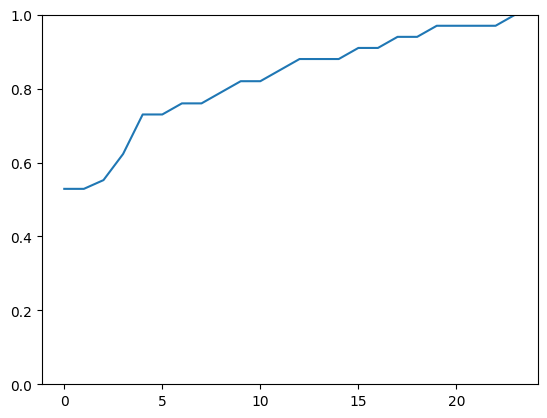

In [35]:
PROBLEM_SIZE = 10
POP_SIZE = 400
ISLANDS = 4 # 1 is the same as no islands
AGENT = Agent.AgentType.PATTERN # Agent.AgentType.BINARY or Agent.AgentType.PATTERN
GENERATIONS = 1000
LAMBDA = 50
MATING_POOL = 50
TOURNAMENT = 4
TRAINING_TYPE = TrainingTypes.TOURNAMENT

fitness = lab9_lib.make_problem(PROBLEM_SIZE)
trainer = AgentIslandsTraining(pop_size=POP_SIZE,problem=fitness,k=1000,islands_number=ISLANDS,agent_type=AGENT)
best_agent , fitnesses = trainer.train(GENERATIONS,training_type=TRAINING_TYPE,lam=LAMBDA,mating_pool_size=MATING_POOL,tournament_size=TOURNAMENT)
print(best_agent)
print(fitness.calls)
plt.plot(fitnesses)
plt.ylim(0, 1)
plt.show()

#### A dumb approach to the problem
Trying to optimize the problem by trying to maximize the fitness bit-by-bit, converge almost instantly for n = 1, but can't find anything with 2,5,10 problem size

In [ ]:
def dummy_solution(fitness):
    k = 1000
    agent_slighly_smarter = [random.uniform(0,1) < 0.5 for _ in range(k)]
    agent_fitness = fitness(agent_slighly_smarter)
    while agent_fitness < 1.0:
        for i in range(k):
            temp = deepcopy(agent_slighly_smarter)
            temp[i] = not temp[i]
            temp_fitness = fitness(temp)
            if temp_fitness > agent_fitness:
                agent_slighly_smarter = temp
                agent_fitness = temp_fitness
        print(agent_fitness)
    #print(fitness(agent_slighly_smarter))
    #print(fitness.calls)
    return agent_slighly_smarter
fitness = lab9_lib.make_problem(1)
print(fitness(dummy_solution(fitness)))

#### Hill Climbing approach
Using a "basic" local-search approach like Hill Climbing, we can find a solution for n = 1 with a very low number of calls to the fitness function, but it's unable to find anything for n = 2,5,10

In [ ]:
def hill_climbing(k : int,fitness : AbstractProblem,lam) -> [Agent, list]:
    agent = AgentGA().set_genome(genome_size=k,genome=[random.uniform(0,1) < 0.5 for _ in range(k)])
    agent.compute_fitness(fitness)
    gen = 0
    gene_modifier = 2
    mutation_rate = gene_modifier / k
    fitnesses = []
    while agent.fitness < 1.0 and gen < 1000:
        offspring = []
        for _ in range(lam):
            agent_temp = deepcopy(agent)
            agent_temp.mutation(mutation_rate)
            agent_temp.compute_fitness(fitness)
            offspring.append(agent_temp)
        offspring.append(agent)
        offspring.sort(key=lambda x : x.fitness , reverse=True)
        agent = offspring[0]
        fitnesses.append(agent.fitness)
        gen += 1
        if gen % 10 == 0:
            print(f"gen {gen} : Best fitness : {agent.fitness}")
    return agent , fitnesses

In [ ]:
fitness = lab9_lib.make_problem(1)
agent , fitnesses = hill_climbing(1000,fitness,20)
fitness.calls
plt.plot(fitnesses)